In [ ]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

# Read the CSV file with specified column types
data = pd.read_csv(
    'data_2.csv',
    dtype={
        'Rate': 'float64',
        'Currency': 'string',
        'Maturity': 'string',
        'Year': 'int64'
    },
    parse_dates=['Date']  # Ensure 'Date' column is datetime
)

# Extract last 8 columns (swap rate maturities)
swap_rates = data.iloc[:, -8:]  # Only last 8 columns
currencies = data["Currency"]  # Currency column
dates = data["Date"]  # Date column

# Initialize empty lists for train and validation sets
train_data, val_data = [], []
train_dates, val_dates = [], []
train_currencies, val_currencies = [], []

# Perform train-validation split at the currency level
for currency in currencies.unique():
    currency_data = swap_rates[currencies == currency]  # Select rows for this currency
    currency_dates = dates[currencies == currency]  # Keep corresponding dates
    currency_labels = currencies[currencies == currency]  # Keep currency info

    # 90% train, 10% validation split
    train, val, train_date, val_date, train_curr, val_curr = train_test_split(
        currency_data, currency_dates, currency_labels, test_size=0.1, random_state=42
    )

    train_data.append(train)
    val_data.append(val)
    train_dates.append(train_date)
    val_dates.append(val_date)
    train_currencies.append(train_curr)
    val_currencies.append(val_curr)

# Combine back into DataFrames
train_df = pd.concat(train_data)
val_df = pd.concat(val_data)
train_dates_df = pd.concat(train_dates)
val_dates_df = pd.concat(val_dates)
train_currencies_df = pd.concat(train_currencies)
val_currencies_df = pd.concat(val_currencies)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_df.values, dtype=torch.float32)
val_tensor = torch.tensor(val_df.values, dtype=torch.float32)

# Convert dates and currencies to NumPy for easy indexing
train_dates_np = train_dates_df.to_numpy()
val_dates_np = val_dates_df.to_numpy()
train_currencies_np = train_currencies_df.to_numpy()
val_currencies_np = val_currencies_df.to_numpy()

# === SHUFFLE training data ===
train_indices = np.random.permutation(len(train_tensor))
train_tensor = train_tensor[train_indices]
train_dates_np = train_dates_np[train_indices]
train_currencies_np = train_currencies_np[train_indices]

# === SHUFFLE validation data ===
val_indices = np.random.permutation(len(val_tensor))
val_tensor = val_tensor[val_indices]
val_dates_np = val_dates_np[val_indices]
val_currencies_np = val_currencies_np[val_indices]

# Print tensor shapes for verification
print("Train Tensor Shape:", train_tensor.shape)
print("Validation Tensor Shape:", val_tensor.shape)

# Store tensors with their corresponding dates and currencies
train_data_with_dates_currencies = (train_tensor, train_dates_np, train_currencies_np)
val_data_with_dates_currencies = (val_tensor, val_dates_np, val_currencies_np)

Train Tensor Shape: torch.Size([1226, 8])
Validation Tensor Shape: torch.Size([140, 8])


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

class CenteredSoftmax(nn.Module):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x)) - 0.5

# Define the Autoencoder
class FinanceInformedAutoencoder(nn.Module):
    def __init__(self, latent_dim=3, hidden_dim=10):
        super(FinanceInformedAutoencoder, self).__init__()
        
        # Encoder: Maps input swap rates to latent factors (z1, z2)
        self.encoder = nn.Linear(8, latent_dim, bias=False)  # No bias per FIAE2 model

        # Drift network H: z → μ1, μ2
        self.H_hidden = nn.Linear(latent_dim, latent_dim, bias=False)  # 2D latent to 2D hidden
        self.H_activation = CenteredSoftmax()  # Centered softmax
        self.H_output = nn.Linear(latent_dim, latent_dim, bias=False)  # Hidden to drift terms (μ1, μ2)

        # Volatility network G: z → log(σ1), log(σ2), tanh^-1(ρ1)
        self.G_hidden = nn.Linear(latent_dim, latent_dim + 3, bias=False)  # 2D latent to 3D hidden
        self.G_activation = CenteredSoftmax()  # Centered softmax
        self.G_output = nn.Linear(latent_dim + 3, latent_dim + 3, bias=False)  # Hidden to log(σ1), log(σ2), tanh^-1(ρ1)

        # Decoder: Maps latent factors + maturity to zero-coupon rates
        self.decoder_hidden = nn.Linear(latent_dim + 1, hidden_dim, bias=False)
        self.activation = CenteredSoftmax()  # Centered softmax activation
        self.decoder_output = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, x):
        batch_size = x.shape[0]

        # Encode input into latent space
        z = self.encoder(x)

        # ✅ Ensure `z_repeated` is differentiable
        z_repeated = z.unsqueeze(1).repeat(1, 31, 1)
        # Ensure `z_repeated` requires gradients
        z_repeated.requires_grad_(True)

        # Ensure maturities is differentiable by creating it from a tensor that requires gradients
        maturities = torch.linspace(0, 30, steps=31, dtype=torch.float32, device=x.device).unsqueeze(0).expand(batch_size, -1)
        maturities = maturities.clone().detach().requires_grad_(True)  # ✅ Now part of the computational graph

        # Concatenate to form decoder input
        decoder_input = torch.cat([z_repeated, maturities.unsqueeze(-1)], dim=-1)

        # Compute zero-coupon rates
        hidden = self.activation(self.decoder_hidden(decoder_input))
        zero_coupon_rates = self.decoder_output(hidden).squeeze(-1)

        # Compute drift terms (μ1, μ2)
        H_hidden_out = self.H_activation(self.H_hidden(z_repeated))  # Apply hidden layer transformation
        mu = self.H_output(H_hidden_out)  # Compute final drift values

        # Compute G-network outputs
        G_hidden_out = self.G_activation(self.G_hidden(z_repeated))  # Apply hidden layer transformation
        G_out = self.G_output(G_hidden_out)

        # Extract volatility components for all maturities
        sigma1 = torch.exp(G_out[:, :, 0])
        sigma2 = torch.exp(G_out[:, :, 1])
        sigma3 = torch.exp(G_out[:, :, 2])
        rho12 = torch.tanh(G_out[:, :, 3])
        rho13 = torch.tanh(G_out[:, :, 4])
        rho23 = torch.tanh(G_out[:, :, 5])

        # Construct sigma matrix for each maturity
        sigma_matrix = torch.zeros(batch_size, 31, 3, 3, device=x.device)  # Shape: (batch_size, 31, 2, 2)
        sigma_matrix[:, :, 0, 0] = sigma1
        sigma_matrix[:, :, 1, 0] = rho12 * sigma2
        sigma_matrix[:, :, 1, 1] = torch.sqrt(1 - rho12 ** 2) * sigma2
        sigma_matrix[:, :, 2, 0] = rho13 * sigma3
        sigma_matrix[:, :, 2, 1] = (
            rho23 - rho12 * rho13
        ) / (torch.sqrt(1 - rho12 ** 2)) * sigma3
        sigma_matrix[:, :, 2, 2] = torch.sqrt(
            torch.clamp(
                1 - rho13 ** 2 - ((rho23 - rho12 * rho13) / (torch.sqrt(1 - rho12 ** 2) + 1e-6)) ** 2,
                min=1e-6)) * sigma3

        # Extract risk-neutral short rate
        risk_neutral_rate = zero_coupon_rates[:, 0].unsqueeze(1).repeat(1, 31)

        discount_factors = torch.exp(-zero_coupon_rates * maturities)

        gradients_maturities = torch.autograd.grad(
            outputs=discount_factors,
            inputs=maturities,
            grad_outputs=torch.ones_like(discount_factors),
            create_graph=True
        )[0]


        # ✅ Compute first derivative w.r.t. latent variables (z_repeated)
        gradients_latent = torch.autograd.grad(
            outputs=discount_factors,  # Output to differentiate
            inputs=z_repeated,          # Input variable to differentiate w.r.t.
            grad_outputs=torch.ones_like(discount_factors),  # Vector-Jacobian product
            create_graph=True  # Keep computational graph for higher-order gradients
        )[0]

        hessian_list = []
        for i in range(latent_dim):  # Compute second derivatives for each latent variable
            grad2 = torch.autograd.grad(
                gradients_latent[..., i], z_repeated,  # Take derivative w.r.t. each latent var
                grad_outputs=torch.ones_like(gradients_latent[..., i]),
                create_graph=True, allow_unused=False
            )[0]
            hessian_list.append(grad2.unsqueeze(-1))  # Add extra dimension for stacking

        # Stack to get full Hessian (batch_size, 31, latent_dim, latent_dim)
        hessian = torch.cat(hessian_list, dim=-1)

        return zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors

# Convert zero-coupon rates to swap rates
def zero_coupon_to_swap_rates(zero_coupon_rates, maturities):
    zero_coupon_rates = zero_coupon_rates[:, 1:]  # Shape: (batch_size, 30)
    maturities = torch.arange(1, 31, dtype=torch.float32, device=zero_coupon_rates.device).unsqueeze(0)

    discount_factors = torch.exp(-zero_coupon_rates * maturities)
    cumulative_sums = torch.tril(torch.ones(30, 30, device=zero_coupon_rates.device)) @ discount_factors.T
    cumulative_sums = cumulative_sums.T
    swap_rates = (1 - discount_factors) / cumulative_sums

    return swap_rates

def finance_informed_loss(r_t, discount_factors, gradients_latent, hessian, mu, sigma_matrix, gradients_maturities):
    # First term: Market consistency constraint (ensuring short rate condition holds)
    term_1 = -r_t * discount_factors  # (batch_size, 31)

    # Second term: Smoothness in gradients (avoiding arbitrage in term structure)
    term_2 = gradients_maturities  # (batch_size, 31)

    # Third term: Latent space drift must align with risk-neutral dynamics
    term_3 = torch.sum(gradients_latent * mu, dim=2)  # (batch_size, 31)

    # Fourth term: Arbitrage-free condition (ensuring no mispricing via Hessian)
    sigma_H_sigma = torch.matmul(
        sigma_matrix.transpose(-1, -2),                  # (batch_size, 31, 3, 3)
        torch.matmul(hessian, sigma_matrix)              # (batch_size, 31, 3, 3)
    )
    trace_sigma_H_sigma = (
        sigma_H_sigma[..., 0, 0] +
        sigma_H_sigma[..., 1, 1] +
        sigma_H_sigma[..., 2, 2]
    )  # (batch_size, 31)

    term_4 = 0.5 * trace_sigma_H_sigma  # (batch_size, 31)

    terms = term_1 - term_2 + term_3 + term_4  # (batch_size, 31)

    # Arbitrage loss: mean squared deviation
    arbitrage_loss = torch.mean(terms ** 2)

    return arbitrage_loss, terms

# Set fixed parameters
initial_learning_rate = 0.01  # Initial LR
batch_size = 32
latent_dim = 3
hidden_dim = 10
epochs = 100

# Prepare data loaders
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=batch_size, shuffle=False)

# Initialize model, optimizer, and loss function
model = FinanceInformedAutoencoder(latent_dim=latent_dim, hidden_dim=hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)

# Learning rate scheduler
def lr_lambda(epoch):
    return 0.9 ** (epoch // 50)  # Decays every 50 epochs
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

criterion = nn.MSELoss()
train_losses = []
val_losses = []
train_arbitrage = []
val_arbitrage = []

best_val_loss = float('inf')
best_model_state = None

# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for X_batch in train_loader:
        optimizer.zero_grad()
        zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(X_batch)
        swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
        arbitrage_loss, terms = finance_informed_loss(risk_neutral_rate, discount_factors, gradients_latent, hessian, mu, sigma_matrix, gradients_maturities)
        mse_train = criterion(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], X_batch)
        loss = mse_train + arbitrage_loss
        loss.backward()
        optimizer.step()
        total_train_loss += mse_train.item()
    
    avg_train_loss = (total_train_loss / len(train_loader)) ** 0.5  # Convert MSE to RMSE
    train_losses.append(avg_train_loss)
    avg_train_arbitrage = torch.mean(abs(terms))
    train_arbitrage.append(avg_train_arbitrage)
    
    # Validation
    model.eval()
    total_val_loss = 0
    for X_batch in val_loader:
        zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(X_batch)
        swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
        arbitrage_loss, terms = finance_informed_loss(risk_neutral_rate, discount_factors, gradients_latent, hessian, mu, sigma_matrix, gradients_maturities)
        mse_val = criterion(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], X_batch)
        val_loss = mse_val + arbitrage_loss
        total_val_loss += mse_val.item()
    
    avg_val_loss = (total_val_loss / len(val_loader)) ** 0.5  # Convert MSE to RMSE
    val_losses.append(avg_val_loss)
    avg_val_arbitrage = torch.mean(abs(terms))
    val_arbitrage.append(avg_val_arbitrage)
    
    # Update learning rate scheduler
    scheduler.step()

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
    
    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Train RMSE: {avg_train_loss:.6f}, Val RMSE: {avg_val_loss:.6f}, LR: {scheduler.get_last_lr()[0]:.6f}")

model.load_state_dict(best_model_state)  # Restore best version
torch.save(best_model_state, "best_fiae3_model.pt")  # Save for later

Epoch 0, Train RMSE: 0.017862, Val RMSE: 0.011585, LR: 0.010000
Epoch 100, Train RMSE: 0.002107, Val RMSE: 0.001725, LR: 0.008100
Epoch 200, Train RMSE: 0.001057, Val RMSE: 0.001134, LR: 0.006561
Epoch 300, Train RMSE: 0.001073, Val RMSE: 0.000847, LR: 0.005314
Epoch 400, Train RMSE: 0.000910, Val RMSE: 0.000813, LR: 0.004305
Epoch 500, Train RMSE: 0.001223, Val RMSE: 0.000835, LR: 0.003487
Epoch 600, Train RMSE: 0.000871, Val RMSE: 0.000782, LR: 0.002824
Epoch 700, Train RMSE: 0.000872, Val RMSE: 0.000715, LR: 0.002288
Epoch 800, Train RMSE: 0.000746, Val RMSE: 0.000660, LR: 0.001853
Epoch 900, Train RMSE: 0.000676, Val RMSE: 0.000606, LR: 0.001501
Epoch 1000, Train RMSE: 0.000644, Val RMSE: 0.000567, LR: 0.001216
Epoch 1100, Train RMSE: 0.000619, Val RMSE: 0.000548, LR: 0.000985
Epoch 1200, Train RMSE: 0.000601, Val RMSE: 0.000530, LR: 0.000798
Epoch 1300, Train RMSE: 0.000588, Val RMSE: 0.000520, LR: 0.000646
Epoch 1400, Train RMSE: 0.000587, Val RMSE: 0.000514, LR: 0.000523
Epoch 1

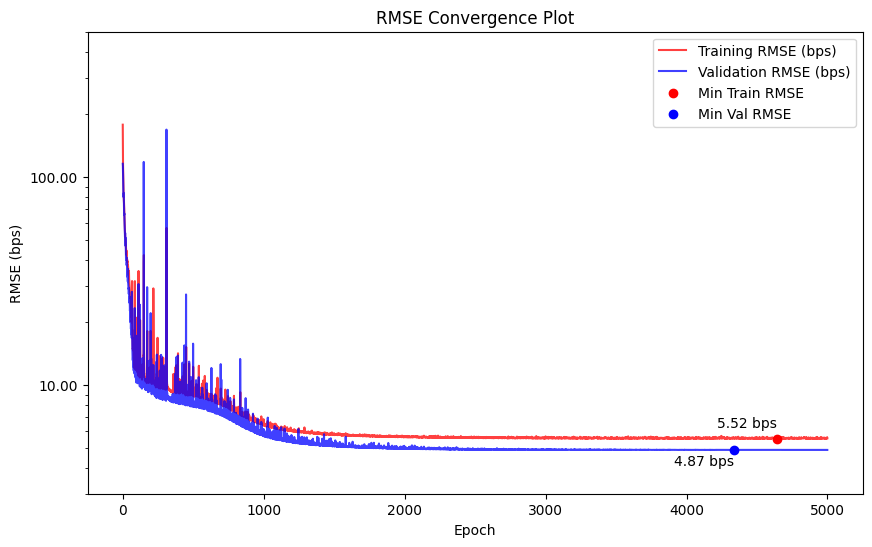

In [61]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Convert RMSE values to basis points (bps)
train_losses_bps = [loss * 10_000 for loss in train_losses]
val_losses_bps = [loss * 10_000 for loss in val_losses]

# Find min RMSE values in basis points and corresponding epochs
min_train_rmse_bps = min(train_losses_bps)
min_train_epoch = train_losses_bps.index(min_train_rmse_bps)

min_val_rmse_bps = min(val_losses_bps)
min_val_epoch = val_losses_bps.index(min_val_rmse_bps)

# Plot RMSE convergence
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses_bps, label='Training RMSE (bps)', alpha=0.75, color = "red")
plt.plot(range(epochs), val_losses_bps, label='Validation RMSE (bps)', alpha=0.75, color = "blue")

# Highlight min points
plt.scatter(min_train_epoch, min_train_rmse_bps, color='red', zorder=3, label='Min Train RMSE')
plt.scatter(min_val_epoch, min_val_rmse_bps, color='blue', zorder=3, label='Min Val RMSE')

# Annotate min points with their values in basis points
plt.text(min_train_epoch, min_train_rmse_bps + 0.5, f"{min_train_rmse_bps:.2f} bps", 
         verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

plt.text(min_val_epoch, min_val_rmse_bps - 0.9, f"{min_val_rmse_bps:.2f} bps", 
         verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

plt.xlabel('Epoch')
plt.ylabel('RMSE (bps)')
plt.yscale('log')  # Log-scale y-axis
plt.ylim(3, 500)
plt.yticks([10, 100])
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
plt.title('RMSE Convergence Plot')
plt.legend()
plt.show()

In [18]:
import pandas as pd
import torch
import torch.nn as nn

# Load the saved weights
#model.load_state_dict(torch.load("best_fiae2_model.pt"))

# Set to evaluation mode if you are using the model for inference
model.eval()

# Load full data (already wide format)
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])

# Filter for test data from 2023 and 2024
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()

def finance_informed_loss_abs(r_t, discount_factors, gradients_latent, hessian, mu, sigma_matrix, gradients_maturities):
    # First term: Market consistency constraint
    term_1 = -r_t * discount_factors  # shape: (batch_size, 31)

    # Second term: Smoothness in gradients
    term_2 = gradients_maturities  # shape: (batch_size, 31)

    # Third term: Latent space drift
    term_3 = torch.sum(gradients_latent * mu, dim=2)  # shape: (batch_size, 31)

    # Fourth term: Arbitrage-free condition via Hessian
    sigma_H_sigma = torch.matmul(
        sigma_matrix.transpose(-1, -2),                 # shape: (batch_size, 31, 3, 3)
        torch.matmul(hessian, sigma_matrix)             # shape: (batch_size, 31, 3, 3)
    )
    trace_sigma_H_sigma = sigma_H_sigma[..., 0, 0] + sigma_H_sigma[..., 1, 1] + sigma_H_sigma[..., 2, 2]  # shape: (batch_size, 31)

    term_4 = 0.5 * trace_sigma_H_sigma  # shape: (batch_size, 31)

    # Total arbitrage loss (absolute version)
    arbitrage_loss = torch.mean(torch.abs(term_1 - term_2 + term_3 + term_4))

    return arbitrage_loss

# Define function to compute RMSE and Arbitrage Loss
def compute_metrics(model, data_tensor):
    model.eval()
    zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(data_tensor)
    swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)

    # Compute RMSE (Mean Squared Error)
    mse_loss = nn.MSELoss()(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], data_tensor)
    rmse = mse_loss.sqrt().item() * 10_000  # Convert to basis points (bps)

    # Compute Absolute Arbitrage Loss
    arbitrage_loss = finance_informed_loss_abs(risk_neutral_rate, discount_factors, gradients_latent, hessian, mu, sigma_matrix, gradients_maturities)
    abs_arbitrage = arbitrage_loss.item() * 10_000 # Take absolute value

    return rmse, abs_arbitrage

# Compute RMSE and Arbitrage Loss for each currency
currency_metrics = []
for currency in currencies.unique():
    currency_train_tensor = torch.tensor(
        train_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_val_tensor = torch.tensor(
        val_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_test_tensor = torch.tensor(
        test_df[test_df['Currency'] == currency].iloc[:, 2:].values, dtype=torch.float32
    )

    train_rmse, train_arbitrage = compute_metrics(model, currency_train_tensor)
    val_rmse, val_arbitrage = compute_metrics(model, currency_val_tensor)
    test_rmse, test_arbitrage = compute_metrics(model, currency_test_tensor)

    currency_metrics.append({
        "Currency": currency,
        "Train RMSE (bps)": train_rmse,
        "Validation RMSE (bps)": val_rmse,
        "Test RMSE (bps)": test_rmse,
        "Train Absolute Arbitrage Loss": train_arbitrage,
        "Validation Absolute Arbitrage Loss": val_arbitrage,
        "Test Absolute Arbitrage Loss": test_arbitrage
    })

# Convert to DataFrame
rmse_df = pd.DataFrame(currency_metrics)

# Add average row
average_train_rmse = rmse_df["Train RMSE (bps)"].mean()
average_val_rmse = rmse_df["Validation RMSE (bps)"].mean()
average_train_arbitrage_loss = rmse_df["Train Absolute Arbitrage Loss"].mean()
average_val_arbitrage_loss = rmse_df["Validation Absolute Arbitrage Loss"].mean()

rmse_df.loc[len(rmse_df)] = [
    "Average",
    rmse_df["Train RMSE (bps)"].mean(),
    rmse_df["Validation RMSE (bps)"].mean(),
    rmse_df["Test RMSE (bps)"].mean(),
    rmse_df["Train Absolute Arbitrage Loss"].mean(),
    rmse_df["Validation Absolute Arbitrage Loss"].mean(),
    rmse_df["Test Absolute Arbitrage Loss"].mean()
]

# Print DataFrame
print(rmse_df.to_string(index=False))

Currency  Train RMSE (bps)  Validation RMSE (bps)  Test RMSE (bps)  Train Absolute Arbitrage Loss  Validation Absolute Arbitrage Loss  Test Absolute Arbitrage Loss
     AUD          6.264013               4.483451         8.845693                       2.015959                            1.610968                      2.298266
     CAD          5.857475               6.271492        13.370833                       2.089981                            1.890388                      5.941499
     DKK          5.402513               3.027570        10.857270                       2.055941                            1.914114                      4.114485
     EUR          5.317500               4.452730        11.930459                       2.124178                            2.214914                      4.675731
     GBP          4.765309               4.884559              NaN                       2.542295                            2.898675                           NaN
     JPY        

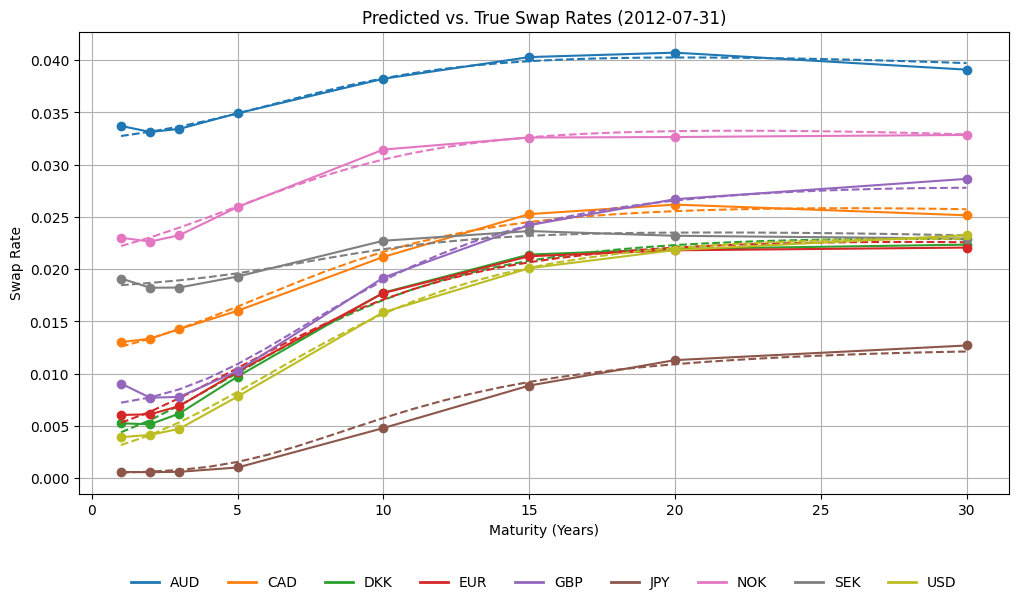

In [19]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Unpack train and validation tensors, dates, and currencies
train_tensor, train_dates_np, train_currencies_np = train_data_with_dates_currencies
val_tensor, val_dates_np, val_currencies_np = val_data_with_dates_currencies

# Select data from 2012-07-31
date_filter_train = train_dates_np == np.datetime64("2012-07-31")
date_filter_val = val_dates_np == np.datetime64("2012-07-31")

selected_train_data = train_tensor[date_filter_train]
selected_val_data = val_tensor[date_filter_val]

selected_train_currencies = train_currencies_np[date_filter_train]
selected_val_currencies = val_currencies_np[date_filter_val]

# Combine train and validation data
selected_data = torch.cat((selected_train_data, selected_val_data), dim=0)
selected_currencies = np.concatenate((selected_train_currencies, selected_val_currencies))

# Get model predictions
model.eval()
zero_coupon_rates_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(selected_data)
swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_rates_pred, maturities)  # All 30 maturities

# Extract true swap rates (only for 8 maturities)
true_swap_rates = selected_data

# Define maturities
full_maturities = torch.arange(1, 31).cpu()  # Full 30 maturities for predicted rates
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]  # 8 maturities for true swap rates

# Get unique currencies for plotting
plt.figure(figsize=(12, 6))

color_map = {}
colors = plt.cm.tab10.colors  # Get distinct colors for different currencies

for idx, currency in enumerate(np.unique(selected_currencies)):
    color_map[currency] = colors[idx % len(colors)]  # Assign colors per currency
    
    # Get indices of this currency's data
    currency_indices = np.where(selected_currencies == currency)[0]
    
    if len(currency_indices) > 0:  # Ensure there is data for this currency
        for i in currency_indices:
            # Plot true swap rates (only for 8 selected maturities) as a solid line
            plt.plot(selected_maturities, true_swap_rates[i].cpu(), color=color_map[currency], linestyle='solid', marker='o')

            # Plot predicted swap rates (for all 30 maturities) as a dashed line
            plt.plot(full_maturities, swap_rates_pred[i].detach().cpu().numpy(), color=color_map[currency], linestyle='dashed')

plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.title("Predicted vs. True Swap Rates (2012-07-31)")

# Create legend to only show currency colors
legend_handles = [plt.Line2D([0], [0], color=color_map[currency], lw=2, label=currency) for currency in color_map]
plt.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=min(len(color_map), 9), fontsize=10, frameon=False)

plt.grid()
plt.show()

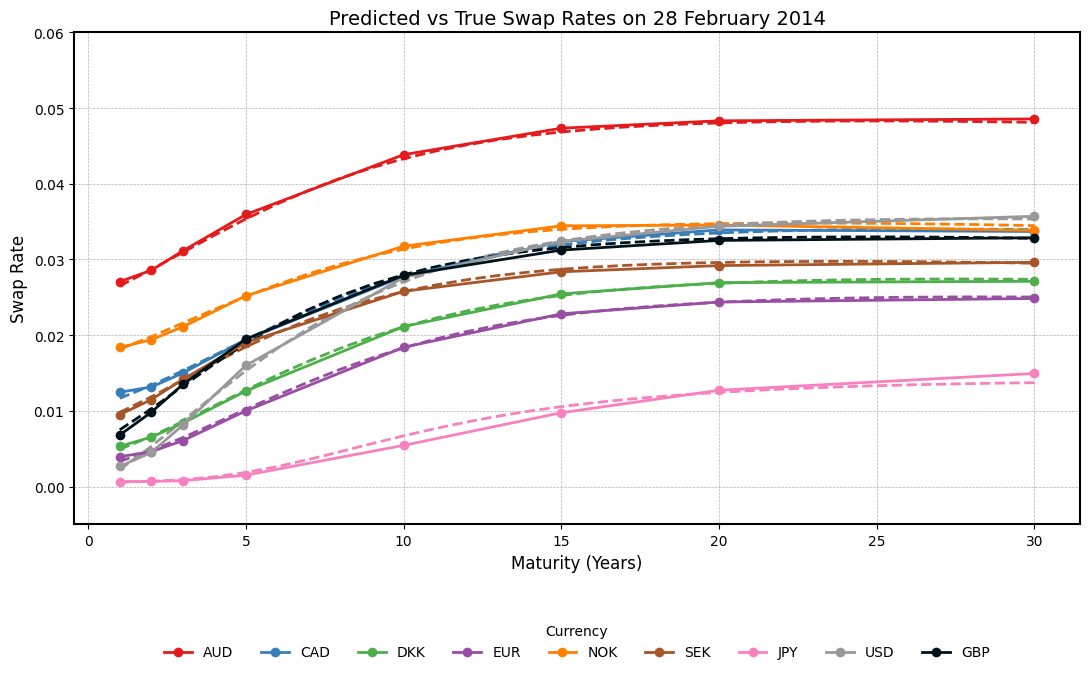

In [20]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Unpack train and validation tensors, dates, and currencies
train_tensor, train_dates_np, train_currencies_np = train_data_with_dates_currencies
val_tensor, val_dates_np, val_currencies_np = val_data_with_dates_currencies

# Filter for target date
target_date = np.datetime64("2014-02-28")
date_filter_train = train_dates_np == target_date
date_filter_val = val_dates_np == target_date

selected_train_data = train_tensor[date_filter_train]
selected_val_data = val_tensor[date_filter_val]

selected_train_currencies = train_currencies_np[date_filter_train]
selected_val_currencies = val_currencies_np[date_filter_val]

# Combine data
selected_data = torch.cat((selected_train_data, selected_val_data), dim=0)
selected_currencies = np.concatenate((selected_train_currencies, selected_val_currencies))

# Get predictions
model.eval()
zero_coupon_rates_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(selected_data)
swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_rates_pred, maturities)  # All 30 maturities

# Define maturities
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

# --- Build long-format DataFrame ---
plot_data = []
for i, currency in enumerate(selected_currencies):
    true_row = selected_data[i].cpu().numpy()
    pred_row = swap_rates_pred[i]

    for m_idx, m in enumerate(selected_maturities):
        plot_data.append({"Maturity": m, "Rate": true_row[m_idx], "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1].item(), "Currency": currency, "Type": "Predicted"})

df_plot = pd.DataFrame(plot_data)

# --- Set desired currency order and colors ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Plot ---
plt.figure(figsize=(11, 7))

# Predicted (dashed lines)
sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle="--",
    legend=False
)

# True (solid lines with filled markers)
true_lines = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

# Customize true markers (bigger + filled)
for line in true_lines.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)
        line.set_markerfacecolor(line.get_color())
        line.set_markeredgewidth(0)

# Axis styling
plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

plt.title("Predicted vs True Swap Rates on 28 February 2014", fontsize=14, ha="center")
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Swap Rate", fontsize=12)

# Legend
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

# Grid and border styling
plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

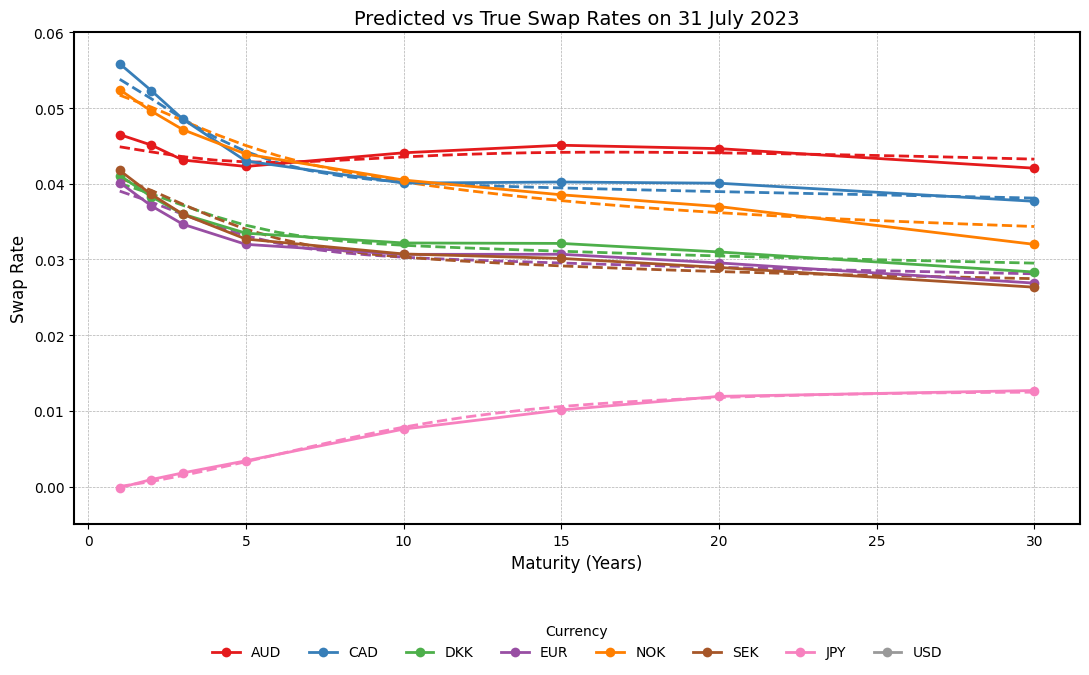

In [21]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load and filter data ---
plot_date = pd.to_datetime("2023-07-31")
data_full["Date"] = pd.to_datetime(data_full["Date"])
filtered_data = data_full[data_full["Date"] == plot_date].copy()

# Extract input swap rates and metadata
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
filtered_data_tensor = torch.tensor(filtered_data[maturity_cols].values, dtype=torch.float32)
filtered_currencies = filtered_data["Currency"].values

# --- Model predictions ---
model.eval()
zero_coupon_rates_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(filtered_data_tensor)
predicted_swaps = zero_coupon_to_swap_rates(zero_coupon_rates_pred, maturities)  # All 30 maturities

# --- Build long-form DataFrame ---
plot_data = []
for i, currency in enumerate(filtered_currencies):
    true_row = filtered_data_tensor[i].numpy()
    pred_row = predicted_swaps[i]
    for m_idx, (maturity, true_rate) in enumerate(zip(maturity_cols, true_row)):
        plot_data.append({"Maturity": int(maturity.rstrip("Y")), "Rate": true_rate, "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1].item(), "Currency": currency, "Type": "Predicted"})

df_plot = pd.DataFrame(plot_data)

# --- Define custom order and palette ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', 'USD']
custom_palette = {
    'AUD': "#E41A1C",
    'CAD': "#377EB8",
    'DKK': "#4DAF4A",
    'EUR': "#984EA3",
    'NOK': "#FF7F00",
    'SEK': "#A65628",
    'JPY': "#F781BF",
    'USD': "#999999",  
}

# --- Plot ---
plt.figure(figsize=(11, 7))

# Predicted curves
sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle='--',
    legend=False
)

# Plot true swap rates (with larger, filled markers)
lineplot = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

# --- Remove white border & increase marker size ---
for line in lineplot.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)                     # Increase size
        line.set_markerfacecolor(line.get_color()) # Fill with line color
        line.set_markeredgewidth(0)                # Remove border


# Axis formatting
plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

# Labels and title
plt.title("Predicted vs True Swap Rates on 31 July 2023", fontsize=14, ha="center")
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Swap Rate", fontsize=12)

# Custom legend with desired order
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=8,
    frameon=False
)

# Grid and styling
plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd

# Combine train and validation datasets into one dataset
data_tensor = torch.cat((train_tensor, val_tensor), dim=0)
data_currencies_np = np.concatenate((train_currencies_np, val_currencies_np))

# Define function for leave-one-currency-out cross-validation
def leave_one_currency_out_cv(model, data_tensor, data_currencies_np):
    unique_currencies = np.unique(data_currencies_np)
    results = []
    
    for left_out_currency in unique_currencies:
        print(f"Leaving out: {left_out_currency}")
        
        # Split data into training and test sets
        train_mask = data_currencies_np != left_out_currency
        test_mask = data_currencies_np == left_out_currency
        
        train_data = data_tensor[train_mask]
        test_data = data_tensor[test_mask]
        
        # Train model on training data
        model.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.9 ** (epoch // 50))
        criterion = torch.nn.MSELoss()
        
        for epoch in range(5000):  # Small number of epochs for demonstration
            zero_coupon_rates_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(train_data)
            swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_rates_pred, maturities)
            loss = criterion(swap_rates_pred[:, [0, 1, 2, 4, 9, 14, 19, 29]], train_data)
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        # Evaluate model on test and train data
        model.eval()
        # RMSE for unseen currency (test set)
        zero_coupon_rates_pred_test, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(test_data)
        swap_rates_pred_test = zero_coupon_to_swap_rates(zero_coupon_rates_pred_test, maturities)
        rmse_unseen = torch.sqrt(criterion(swap_rates_pred_test[:, [0, 1, 2, 4, 9, 14, 19, 29]], test_data)).item() * 10_000  # Convert to basis points
        
        # RMSE for seen currencies (train set)
        zero_coupon_rates_pred_train, _, maturities = model(train_data)
        swap_rates_pred_train = zero_coupon_to_swap_rates(zero_coupon_rates_pred_train, maturities)
        rmse_seen = torch.sqrt(criterion(swap_rates_pred_train[:, [0, 1, 2, 4, 9, 14, 19, 29]], train_data)).item() * 10_000  # Convert to basis points
    
        results.append({"Currency Left Out": left_out_currency, "RMSE Unseen (bps)": rmse_unseen, "RMSE Seen (bps)": rmse_seen})
    
    return results

# Run leave-one-currency-out cross-validation
cv_results = leave_one_currency_out_cv(model, data_tensor, data_currencies_np)

# Print results
cv_results_df = pd.DataFrame(cv_results)
print(cv_results_df.to_string(index=False))

In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

# Prepare 8 observed maturity positions
maturity_labels = [1, 2, 3, 5, 10, 15, 20, 30]
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]

# Function to compute RMSE per maturity for a given tensor
def compute_rmse_per_maturity(model, data_tensor):
    model.eval()
    zero_coupon_rates, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(data_tensor)
    swap_rates = zero_coupon_to_swap_rates(zero_coupon_rates, maturities)
    swap_rates_selected = swap_rates[:, selected_indices]

    mse_per_maturity = torch.mean((swap_rates_selected - data_tensor) ** 2, dim=0)
    rmse_per_maturity = torch.sqrt(mse_per_maturity) * 10_000  # Convert to bps
    return rmse_per_maturity.cpu().detach().numpy()

# Compute per-maturity RMSEs
rmse_train = compute_rmse_per_maturity(model, train_tensor)
rmse_val   = compute_rmse_per_maturity(model, val_tensor)

# Prepare test data
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()
test_tensor = torch.tensor(test_df.iloc[:, 2:].values, dtype=torch.float32)
rmse_test = compute_rmse_per_maturity(model, test_tensor)

# Create DataFrame
rmse_by_maturity = pd.DataFrame({
    "Maturity (Years)": maturity_labels,
    "Train RMSE (bps)": rmse_train,
    "Validation RMSE (bps)": rmse_val,
    "Test RMSE (bps)": rmse_test
})

rmse_by_maturity

Maturity (Years)  Train RMSE (bps)  Validation RMSE (bps)  Test RMSE (bps)
0                 1          8.155128               6.668504        18.329103
1                 2          4.575147               3.642566         7.821221
2                 3          6.157531               5.333372        12.562550
3                 5          4.370967               4.160367         9.128210
4                10          5.196249               4.964296         7.067400
5                15          4.549448               4.226829        10.310323
6                20          2.921904               2.564682         6.630242
7                30          6.777183               6.077825        12.641242

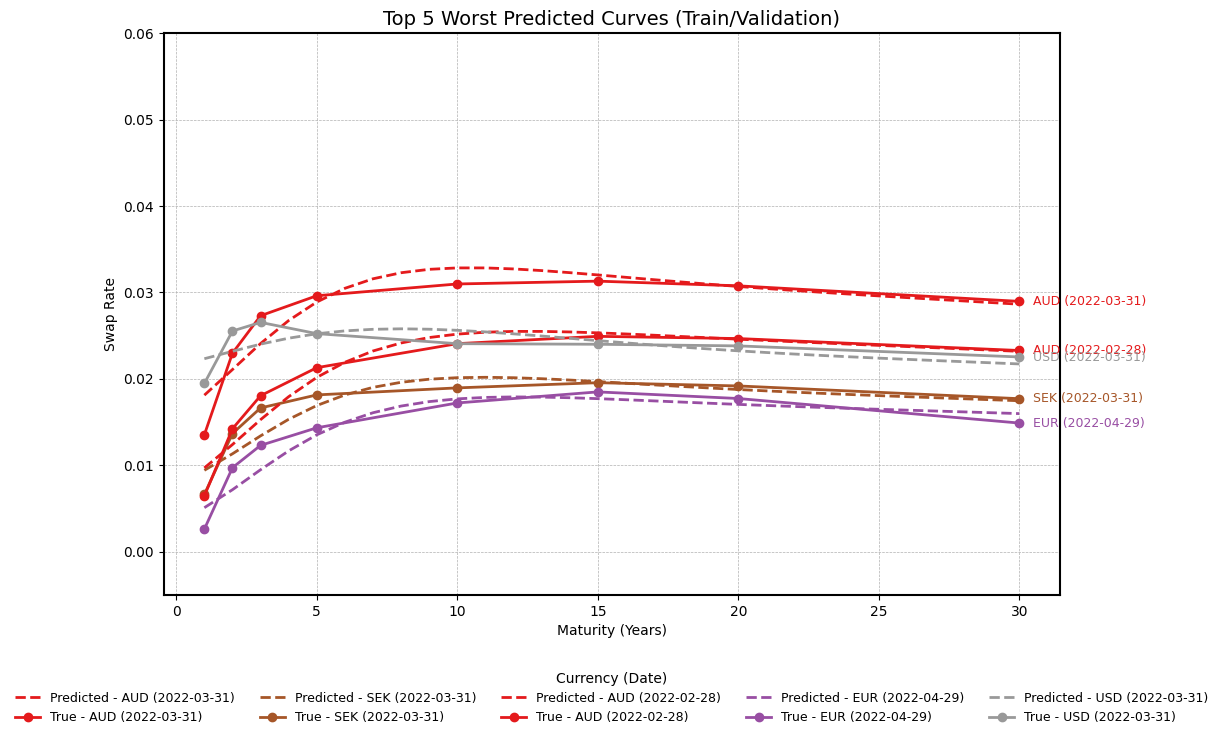

In [32]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# Define distinct marker styles
marker_styles = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']

# --- Setup ---
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}
fallback_color = "#000000"

# Combine train + validation
train_val_tensor = torch.cat((train_tensor, val_tensor), dim=0)
train_val_dates = np.concatenate((train_dates_np, val_dates_np))
train_val_currencies = np.concatenate((train_currencies_np, val_currencies_np))

# --- Model Prediction ---
model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(train_val_tensor)
swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_pred, maturities)
selected_pred = swap_rates_pred[:, selected_indices]
rmse_per_curve = torch.sqrt(torch.mean((selected_pred - train_val_tensor) ** 2, dim=1))

# --- Top 10 worst curves ---
worst_indices = torch.topk(rmse_per_curve, 5).indices.cpu().numpy()

# --- Plot ---
plt.figure(figsize=(12, 8))

for idx in worst_indices:
    currency = train_val_currencies[idx]
    date = pd.to_datetime(train_val_dates[idx]).strftime('%Y-%m-%d')
    color = custom_palette.get(currency, fallback_color)
    label = f"{currency} ({date})"

    true_curve = train_val_tensor[idx].numpy()
    pred_curve = swap_rates_pred[idx].cpu().detach().numpy()

    plt.plot(full_maturities, pred_curve, linestyle="--", linewidth=2, color=color, label=f"Predicted - {label}")
    plt.plot(selected_maturities, true_curve, marker='o', linewidth=2, color=color, label=f"True - {label}")
    # Annotate last point (30Y) of true curve
    plt.text(
        x=selected_maturities[-1] + 0.5,
        y=true_curve[-1],
        s=label,
        fontsize=9,
        color=color,
        verticalalignment='center'
    )


# --- Formatting ---
plt.title("Top 5 Worst Predicted Curves (Train/Validation)", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(range(0, 31, 5))
plt.yticks(np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)
plt.grid(True, linestyle="--", linewidth=0.5)

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

# --- Legend below plot ---
plt.legend(
    title="Currency (Date)",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=5,  # You can set this to 9 if each label is short, but 2–3 is often clearer
    frameon=False,
    fontsize=9,
    title_fontsize=10
)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Add this line to shift plot up for legend space
plt.show()

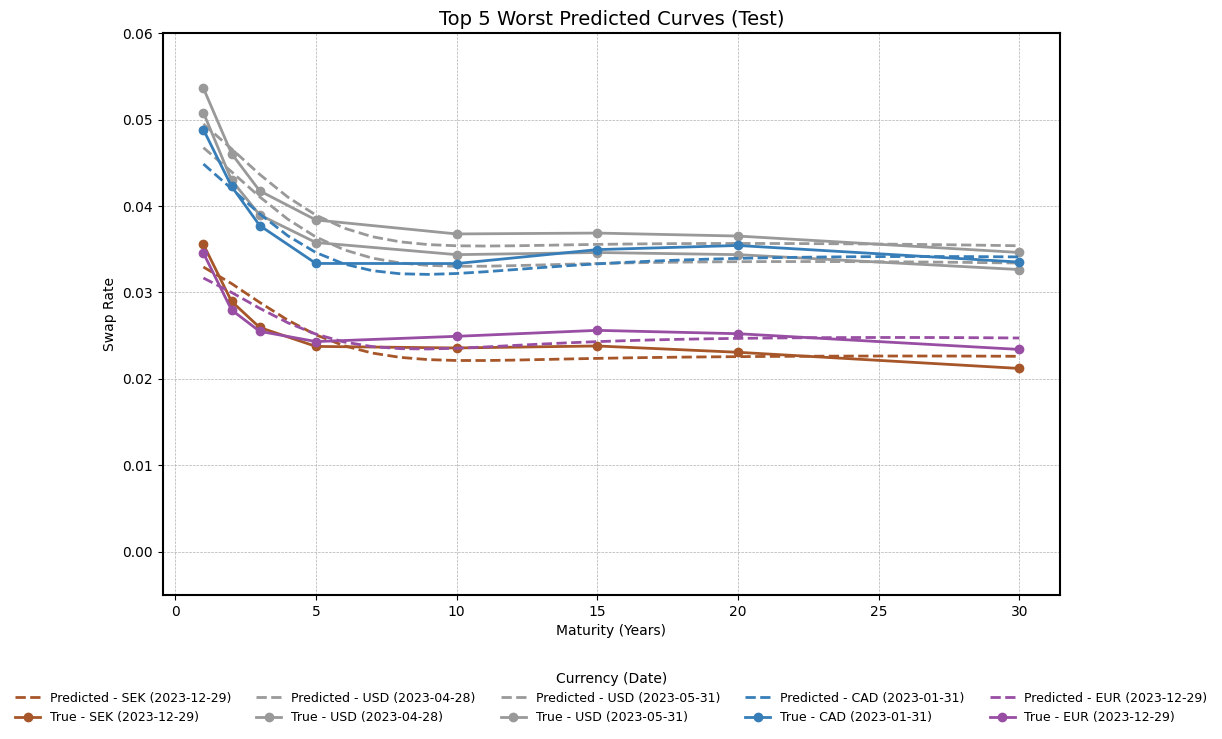

In [33]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- Prepare test data ---
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()
test_tensor = torch.tensor(test_df.iloc[:, 2:].values, dtype=torch.float32)
test_currencies = test_df["Currency"].values
test_dates = test_df["Date"].values

# --- Setup ---
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}
fallback_color = "#000000"

# --- Model Prediction ---
model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(test_tensor)
swap_rates_pred = zero_coupon_to_swap_rates(zero_coupon_pred, maturities)
selected_pred = swap_rates_pred[:, selected_indices]
rmse_per_curve = torch.sqrt(torch.mean((selected_pred - test_tensor) ** 2, dim=1))

# --- Top 5 worst curves ---
worst_indices = torch.topk(rmse_per_curve, 5).indices.cpu().numpy()

# --- Plot ---
plt.figure(figsize=(12, 8))

for idx in worst_indices:
    currency = test_currencies[idx]
    date = pd.to_datetime(test_dates[idx]).strftime('%Y-%m-%d')
    color = custom_palette.get(currency, fallback_color)
    label = f"{currency} ({date})"

    true_curve = test_tensor[idx].numpy()
    pred_curve = swap_rates_pred[idx].cpu().detach().numpy()

    plt.plot(full_maturities, pred_curve, linestyle="--", linewidth=2, color=color, label=f"Predicted - {label}")
    plt.plot(selected_maturities, true_curve, marker='o', linewidth=2, color=color, label=f"True - {label}")

# --- Formatting ---
plt.title("Top 5 Worst Predicted Curves (Test)", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(range(0, 31, 5))
plt.yticks(np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)
plt.grid(True, linestyle="--", linewidth=0.5)

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

# --- Legend below plot ---
plt.legend(
    title="Currency (Date)",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=5,
    frameon=False,
    fontsize=9,
    title_fontsize=10
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

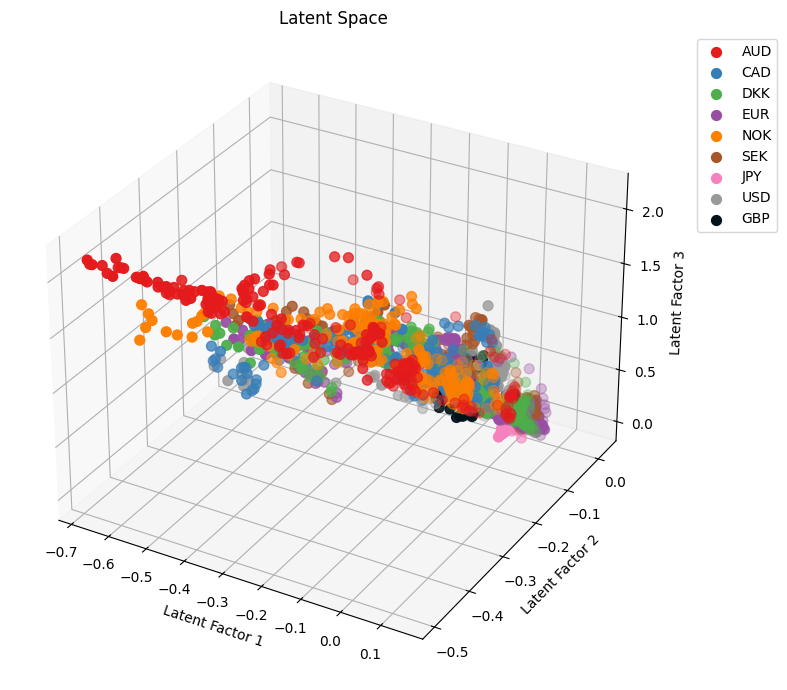

In [43]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D projection

# Load your data
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']

# Split into sets
train_df = data_full[data_full["Date"].dt.year <= 2018].copy()
val_df = data_full[(data_full["Date"].dt.year > 2018) & (data_full["Date"].dt.year < 2023)].copy()
test_df = data_full[data_full["Date"].dt.year >= 2023].copy()

# Add labels
train_df["Set"] = "Train"
val_df["Set"] = "Validation"
test_df["Set"] = "Test"
combined_df = pd.concat([train_df, val_df, test_df])

# Prepare tensors
data_tensor = torch.tensor(combined_df[maturity_cols].values, dtype=torch.float32)
currencies = combined_df["Currency"].values
sets = combined_df["Set"].values

# Run model to get latent variables
# model.load_state_dict(torch.load("best_fiae3_model.pt"))
model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(data_tensor)

# Define palette and order
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# Create DataFrame for plotting
latent_df = pd.DataFrame({
    "Latent_1": z[:, 0].detach().numpy(),
    "Latent_2": z[:, 1].detach().numpy(),
    "Latent_3": z[:, 2].detach().numpy(),
    "Currency": currencies,
    "Set": sets
})

# 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for currency in legend_order:
    subset = latent_df[latent_df["Currency"] == currency]
    ax.scatter(
        subset["Latent_1"],
        subset["Latent_2"],
        subset["Latent_3"],
        label=currency,
        color=custom_palette.get(currency, "#000000"),
        s=50
    )

ax.set_title("Latent Space")
ax.set_xlabel("Latent Factor 1")
ax.set_ylabel("Latent Factor 2")
ax.set_zlabel("Latent Factor 3")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

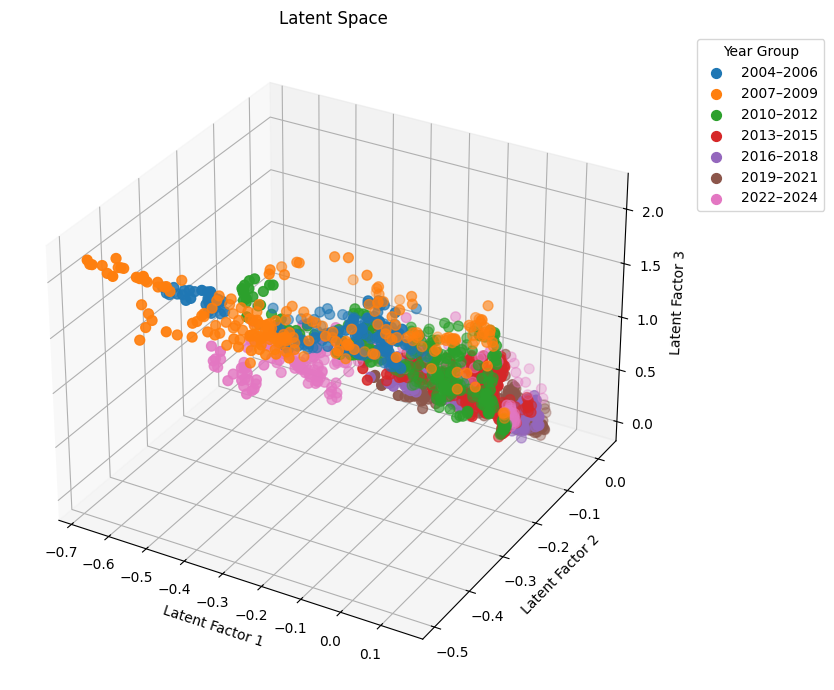

In [44]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Load your data
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year

# Filter to relevant year range
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# Create 3-year grouping like "2004–2006"
def label_year_group(year):
    base = (year - 2004) // 3 * 3 + 2004
    return f"{base}–{base+2}"

data_filtered["YearGroup"] = data_filtered["Year"].apply(label_year_group)

# Prepare input tensor
data_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
year_groups = data_filtered["YearGroup"].values

# Run model
model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(data_tensor)

# Prepare DataFrame for plotting
latent_dim = z.shape[1]
latent_df = pd.DataFrame(z.detach().numpy(), columns=[f"Latent_{i+1}" for i in range(latent_dim)])
latent_df["YearGroup"] = year_groups

# Generate consistent color palette
year_group_order = sorted(latent_df["YearGroup"].unique())
palette = sns.color_palette("tab10", n_colors=len(year_group_order))
year_palette = {grp: col for grp, col in zip(year_group_order, palette)}

# Plotting
if latent_dim == 2:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=latent_df, x="Latent_1", y="Latent_2",
        hue="YearGroup", palette=year_palette, hue_order=year_group_order, s=70
    )
    plt.title("Latent Space Grouped by 3-Year Periods (2D)")
    plt.xlabel("Latent Factor 1")
    plt.ylabel("Latent Factor 2")
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Year Group")
    plt.tight_layout()
    plt.show()

elif latent_dim == 3:
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    #ax.view_init(elev=30, azim=45)
    for group in year_group_order:
        subset = latent_df[latent_df["YearGroup"] == group]
        ax.scatter(
            subset["Latent_1"], subset["Latent_2"], subset["Latent_3"],
            label=group, color=year_palette[group], s=50
        )
    ax.set_title("Latent Space")
    ax.set_xlabel("Latent Factor 1")
    ax.set_ylabel("Latent Factor 2")
    ax.set_zlabel("Latent Factor 3")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Year Group")
    plt.tight_layout()
    plt.show()

else:
    print(f"Latent dimension {latent_dim} not supported for plotting.")

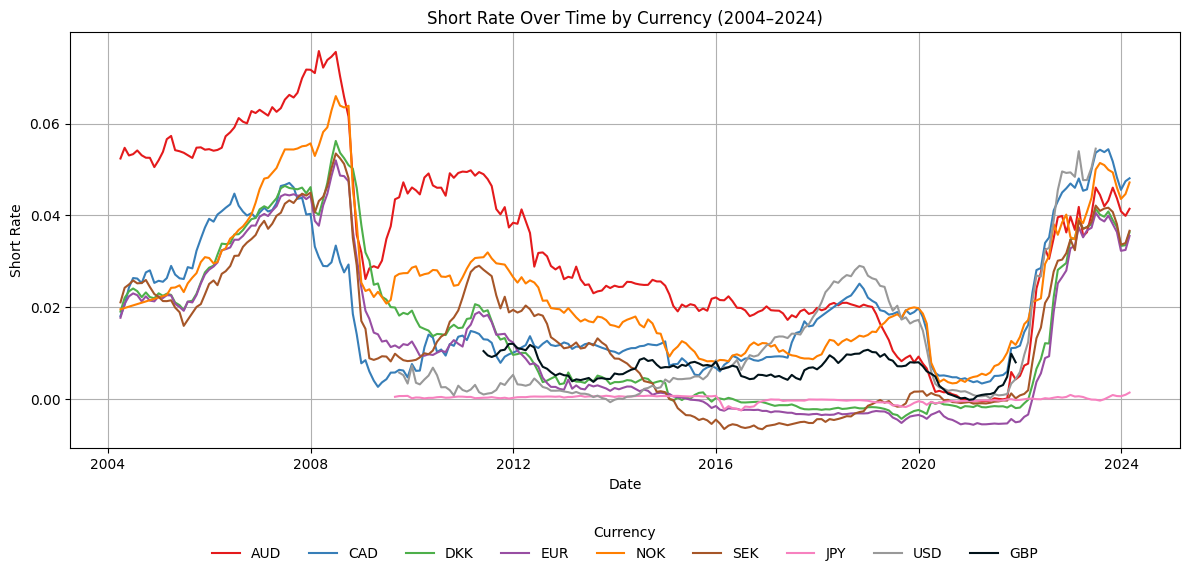

In [45]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
short_rates = risk_neutral_rate[:, 0].cpu().detach().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "RiskNeutralRate": short_rates
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="RiskNeutralRate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title("Short Rate Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel("Short Rate")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

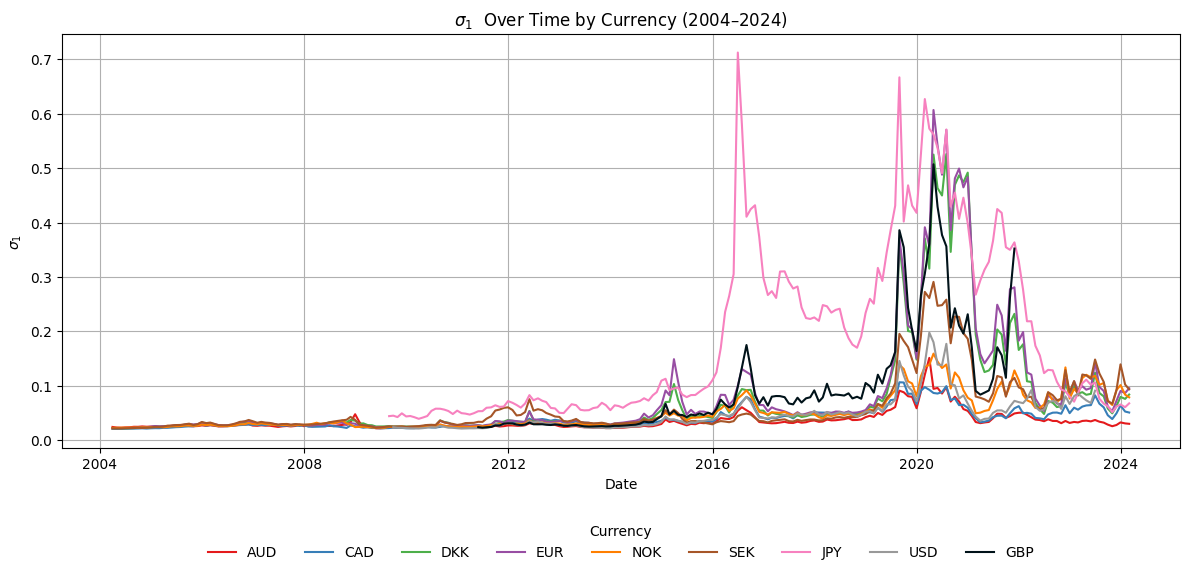

In [46]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
sigma1_at_short_maturity = sigma1[:, 0].detach().cpu().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": sigma1_at_short_maturity
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\sigma_1$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\sigma_1$ ")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

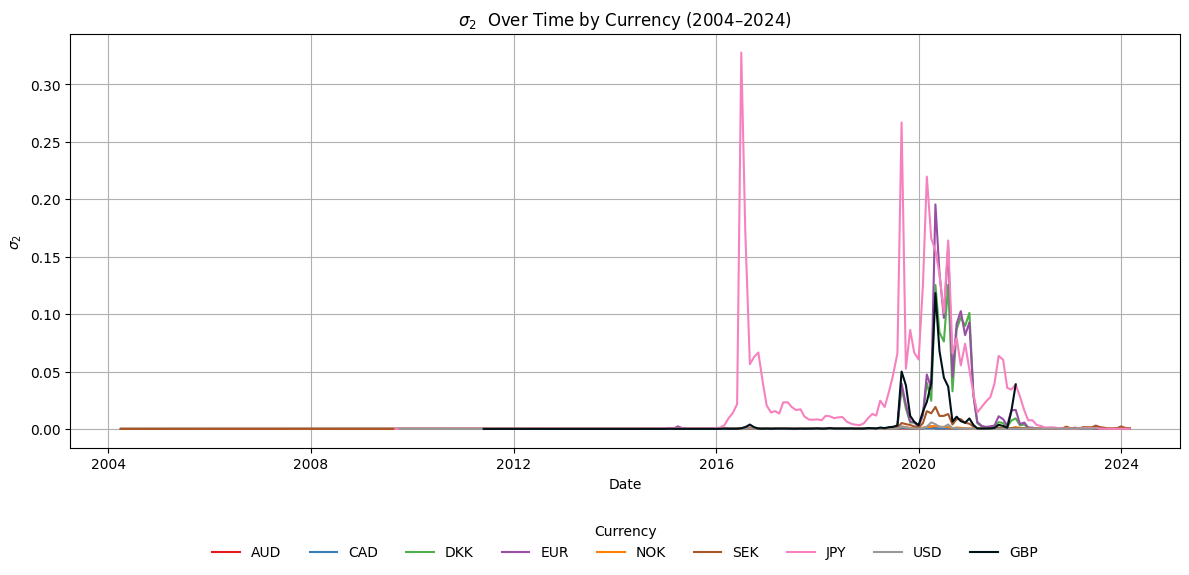

In [47]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
sigma2_at_short_maturity = sigma2[:, 0].detach().cpu().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_2": sigma2_at_short_maturity
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_2",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\sigma_2$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\sigma_2$ ")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

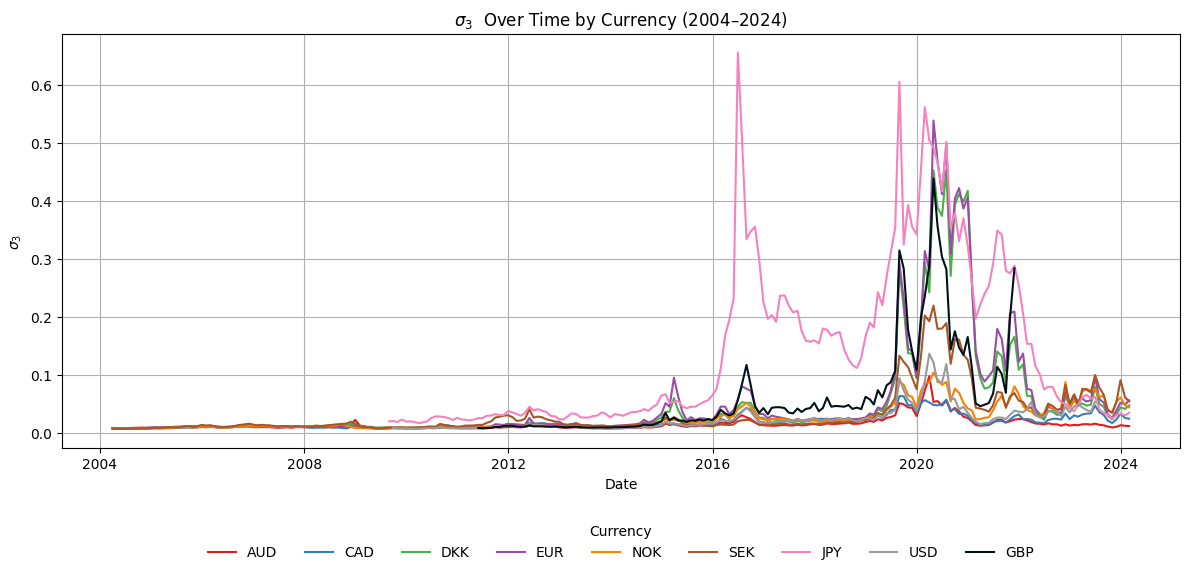

In [48]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
sigma2_at_short_maturity = sigma3[:, 0].detach().cpu().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_2": sigma2_at_short_maturity
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_2",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\sigma_3$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\sigma_3$ ")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

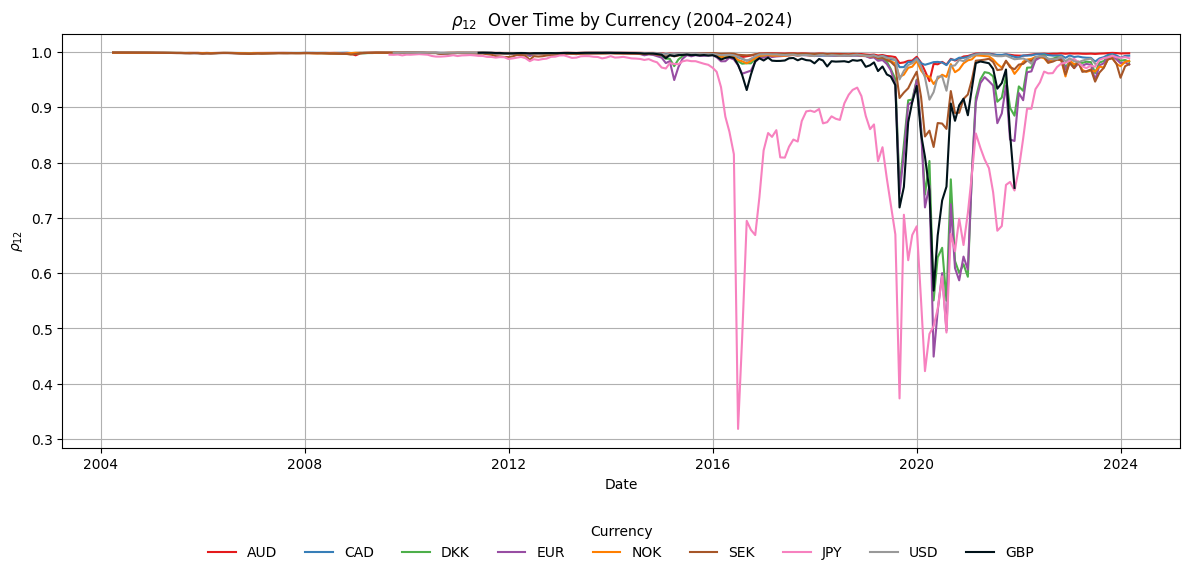

In [49]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
rho = rho12[:, 0].detach().cpu().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "rho": rho
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="rho",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\rho_{12}$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\rho_{12}$")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

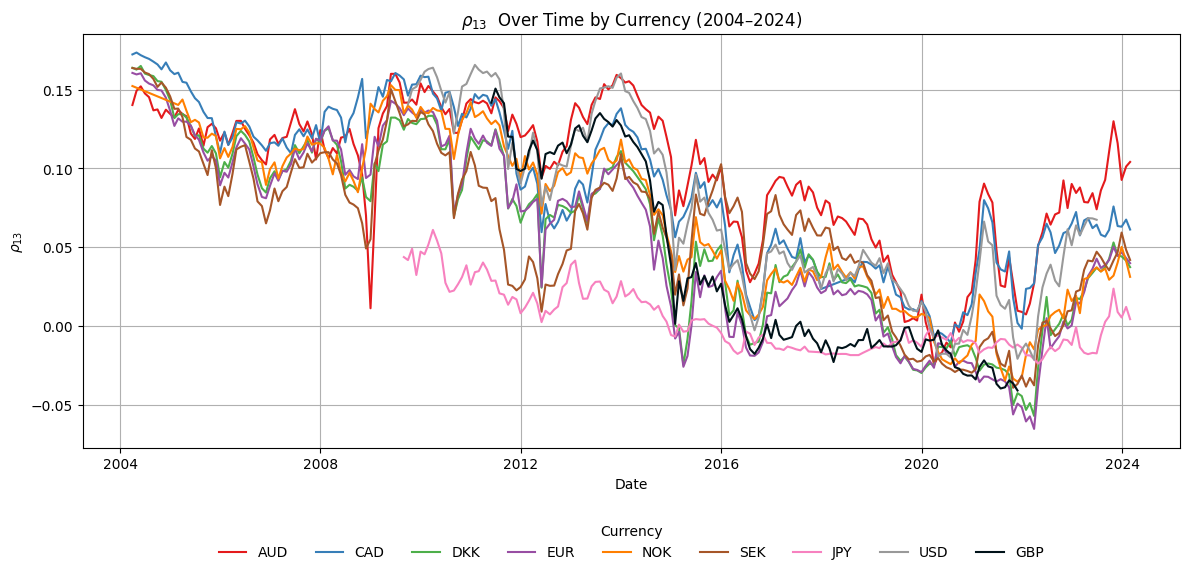

In [50]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
rho = rho13[:, 0].detach().cpu().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "rho": rho
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="rho",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\rho_{13}$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\rho_{13}$")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

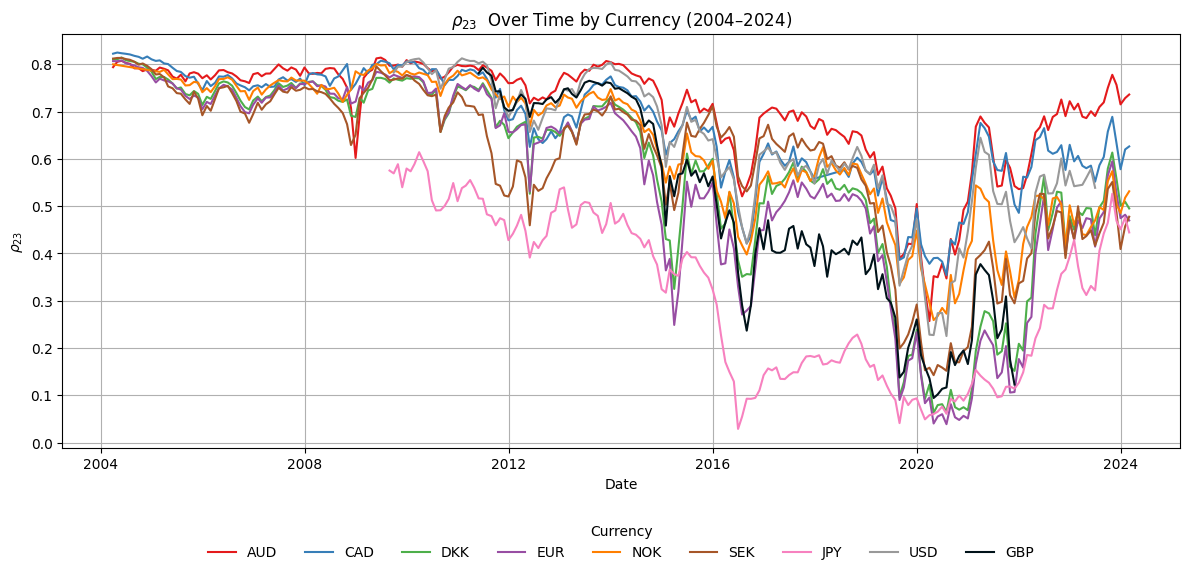

In [51]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
rho = rho23[:, 0].detach().cpu().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "rho": rho
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="rho",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\rho_{23}$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\rho_{23}$")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

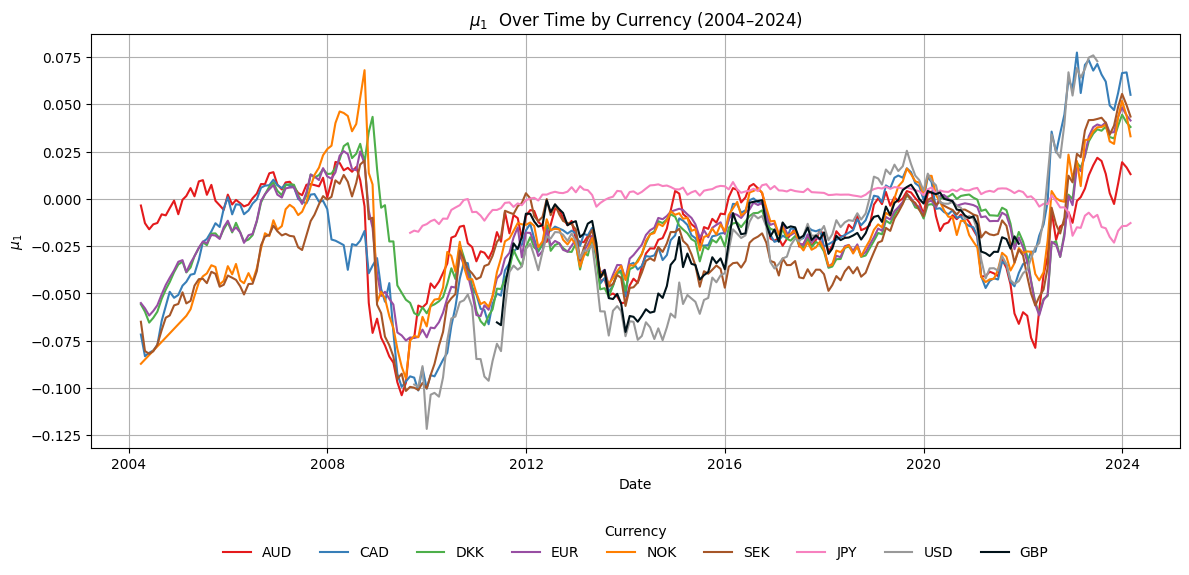

In [52]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
mu1 = mu[:, 0, 0].detach().cpu().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\mu_1$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\mu_1$ ")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

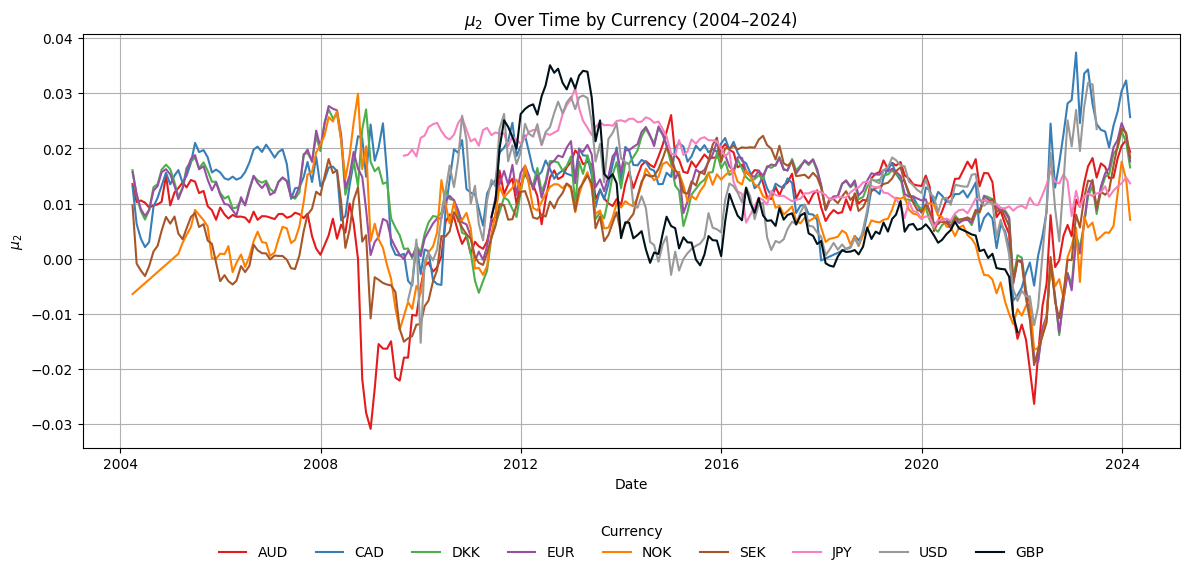

In [53]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
mu1 = mu[:, 0, 1].detach().cpu().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\mu_2$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\mu_2$ ")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

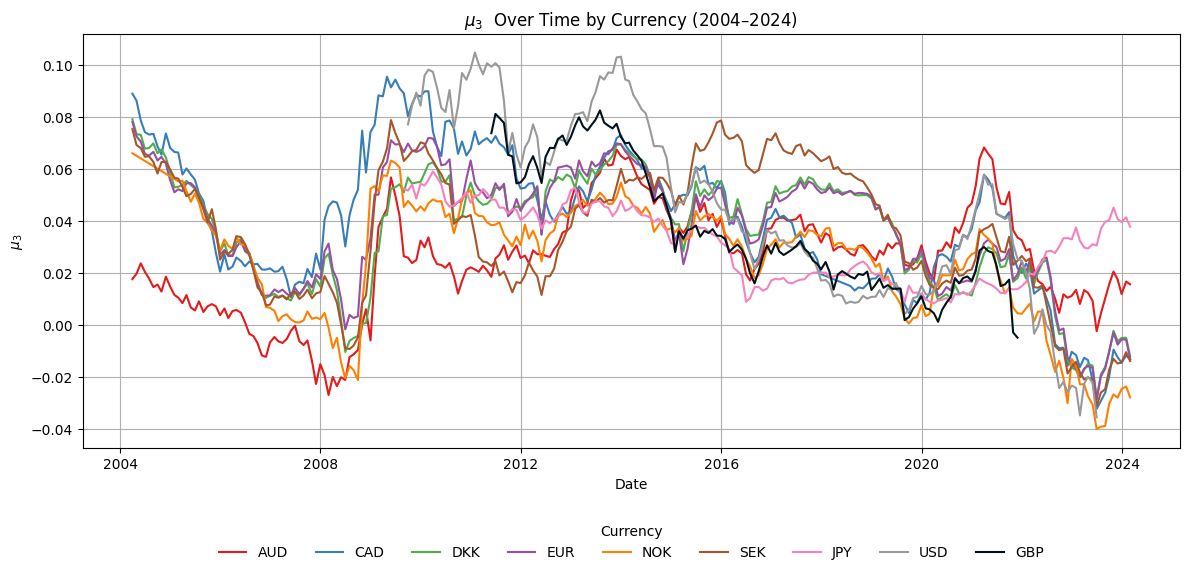

In [54]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
mu1 = mu[:, 0, 2].detach().cpu().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\mu_3$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\mu_3$ ")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

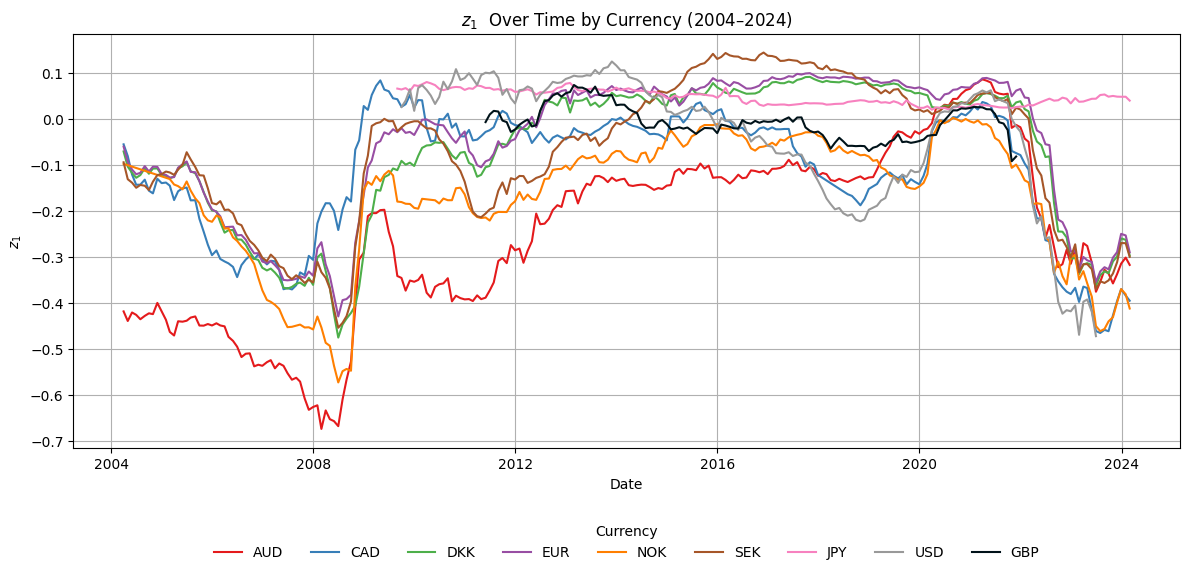

In [55]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
mu1 = z[:, 0].detach().cpu().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$z_1$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$z_1$ ")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

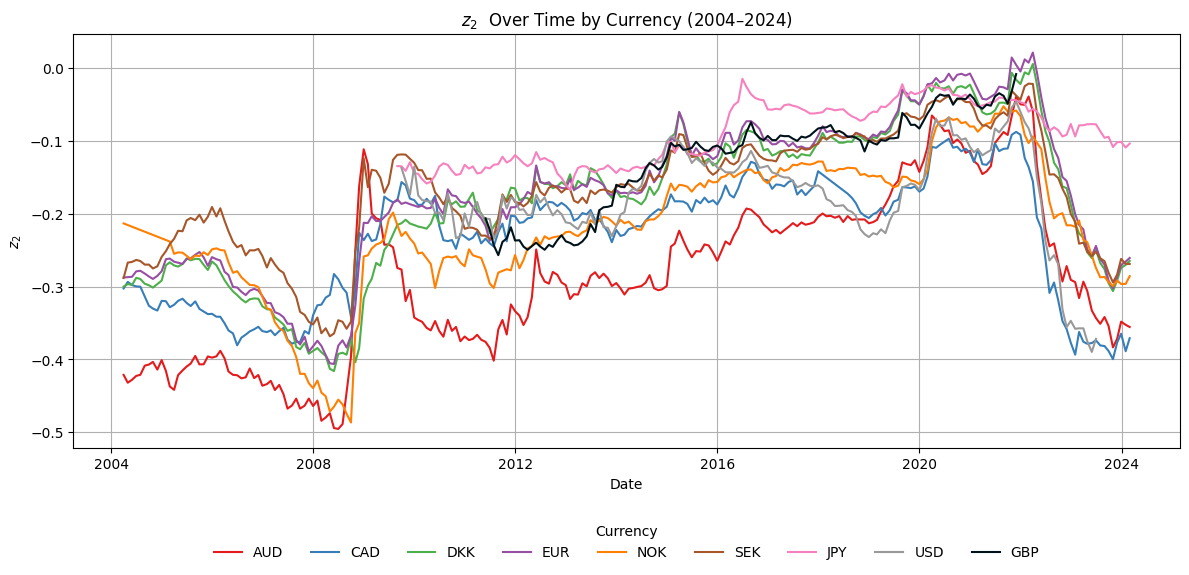

In [56]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
mu1 = z[:, 1].detach().cpu().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$z_2$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$z_2$ ")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

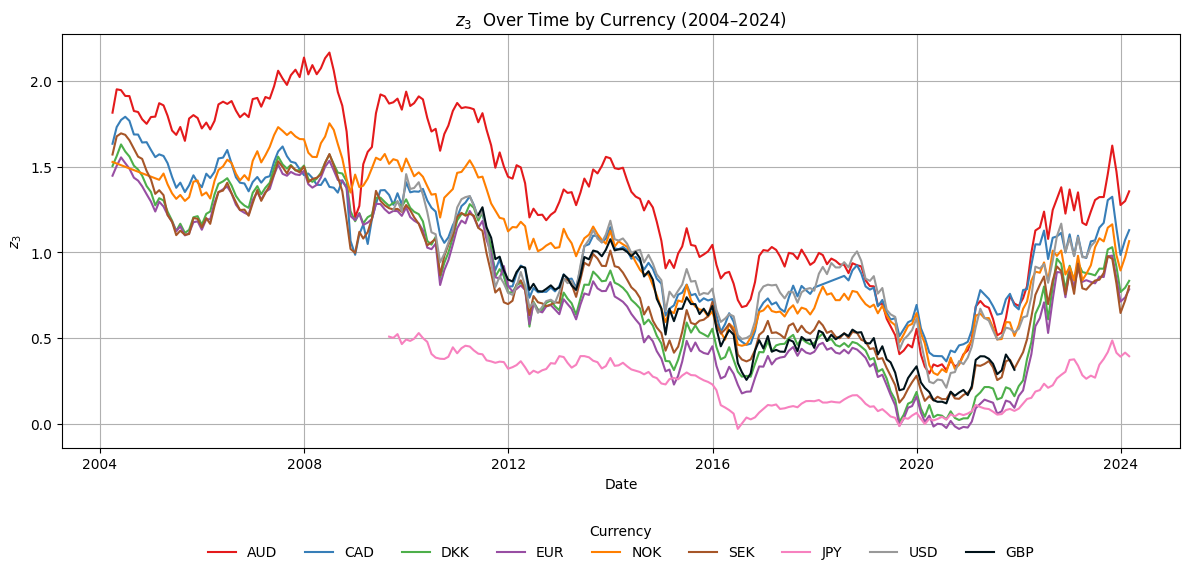

In [57]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define palette and order ---
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

# --- Load and prepare data ---
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

# --- Extract swap rate tensor and metadata ---
x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

# --- Run through model ---
model.eval()
zero_coupon_pred, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, sigma3, rho12, rho13, rho23, discount_factors = model(x_tensor)
mu1 = z[:, 2].detach().cpu().numpy()

# --- Build DataFrame ---
df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

# --- Plot ---
plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$z_3$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$z_3$ ")
plt.grid(True)

# Legend below the plot
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()